In [33]:
import torch
import numpy as np
from dataset import Animal10
import torchvision.transforms as tf
from torchvision.transforms import v2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image

In [10]:
transforms = tf.Compose([
    tf.ToTensor(),
    tf.Resize((224,224)),
    tf.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225)),
    tf.RandomHorizontalFlip(),
    # v2.CutMix(alpha=1,num_classes=10),
])

In [26]:
dataset = Animal10(False,transform=transforms)
data_loader = DataLoader(dataset, 4, True)
cut_mix = v2.CutMix(alpha=1., num_classes=10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.3805, 0.0000, 0.0000, 0.0000, 0.6195,
        0.0000])


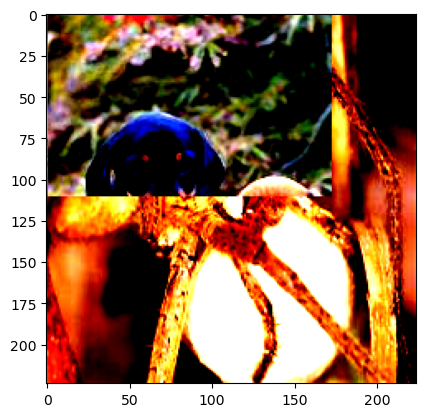

In [47]:
img,label = next(iter(data_loader))
img, label = cut_mix(img,label)
img_p = img.permute(0,2,3,1)
plt.imshow(img_p[0])
print(label[0])
